In [2]:
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(patchwork)
library(hdf5r) 
library(future)
library(RColorBrewer)
library(dplyr)
library(Matrix)
library(BSgenome.Hsapiens.UCSC.hg38)
library(glue)
library(harmony)
library(matrixStats)
library(scales)
library(biomaRt)
library(curl)
library(goseq)
library(httr)
library(Scillus)
library(TFBSTools)
library(JASPAR2020)
library(ggridges)
library(ggrepel)
library(ggsignif)
library(qusage)
library(tidyverse)
httr::set_config(config(ssl_verifypeer = 0L))
set.seed(1234)
setwd('data/inhouse_wu_long_yu/')

In [3]:
source('/home/jupyter/scATAC_analysis/edit/snatac-rcc-manuscript-data/functions.r')

# Figure S3A-B: ccRCC epigenetic programs and epigenetic modifier mutation status

Load in data

In [6]:
ccrcc = readRDS('allcells/tumor/seurat_obj/integrated_ccrcc_c0123_plof_anno_Oct2023.rds')
sigpeaks = read.table('../../snatac-rcc-manuscript-data/s2b_ccrcc_states_diffpeaks.txt',sep = '\t', header = T)

Calculate epigenetic program signature scores

In [7]:
results = list()
for (cluster in c('C1','C2','C3')) {
    peaks = (sigpeaks %>% filter(cluster == !!cluster))$peak
    sig = calculate_signature_scores(seurat_object = ccrcc, sig_peak_set = peaks, pct.open = 0.1, final_score_name = glue('{cluster}_signature'))
    results[[cluster]] = sig
}
signature_df = dplyr::bind_cols(results)
ccrcc = AddMetaData(ccrcc, signature_df)

Matching GC.percent distribution

Matching GC.percent distribution

Matching GC.percent distribution



## Panel A: All stages

In these plots, we compare the signature score for a given program between tumors with a given mutation to wild type. Including tumors from patients with all disease stages. 

`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed"
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed"
Warning message:
"Computation failed in `stat_signif()

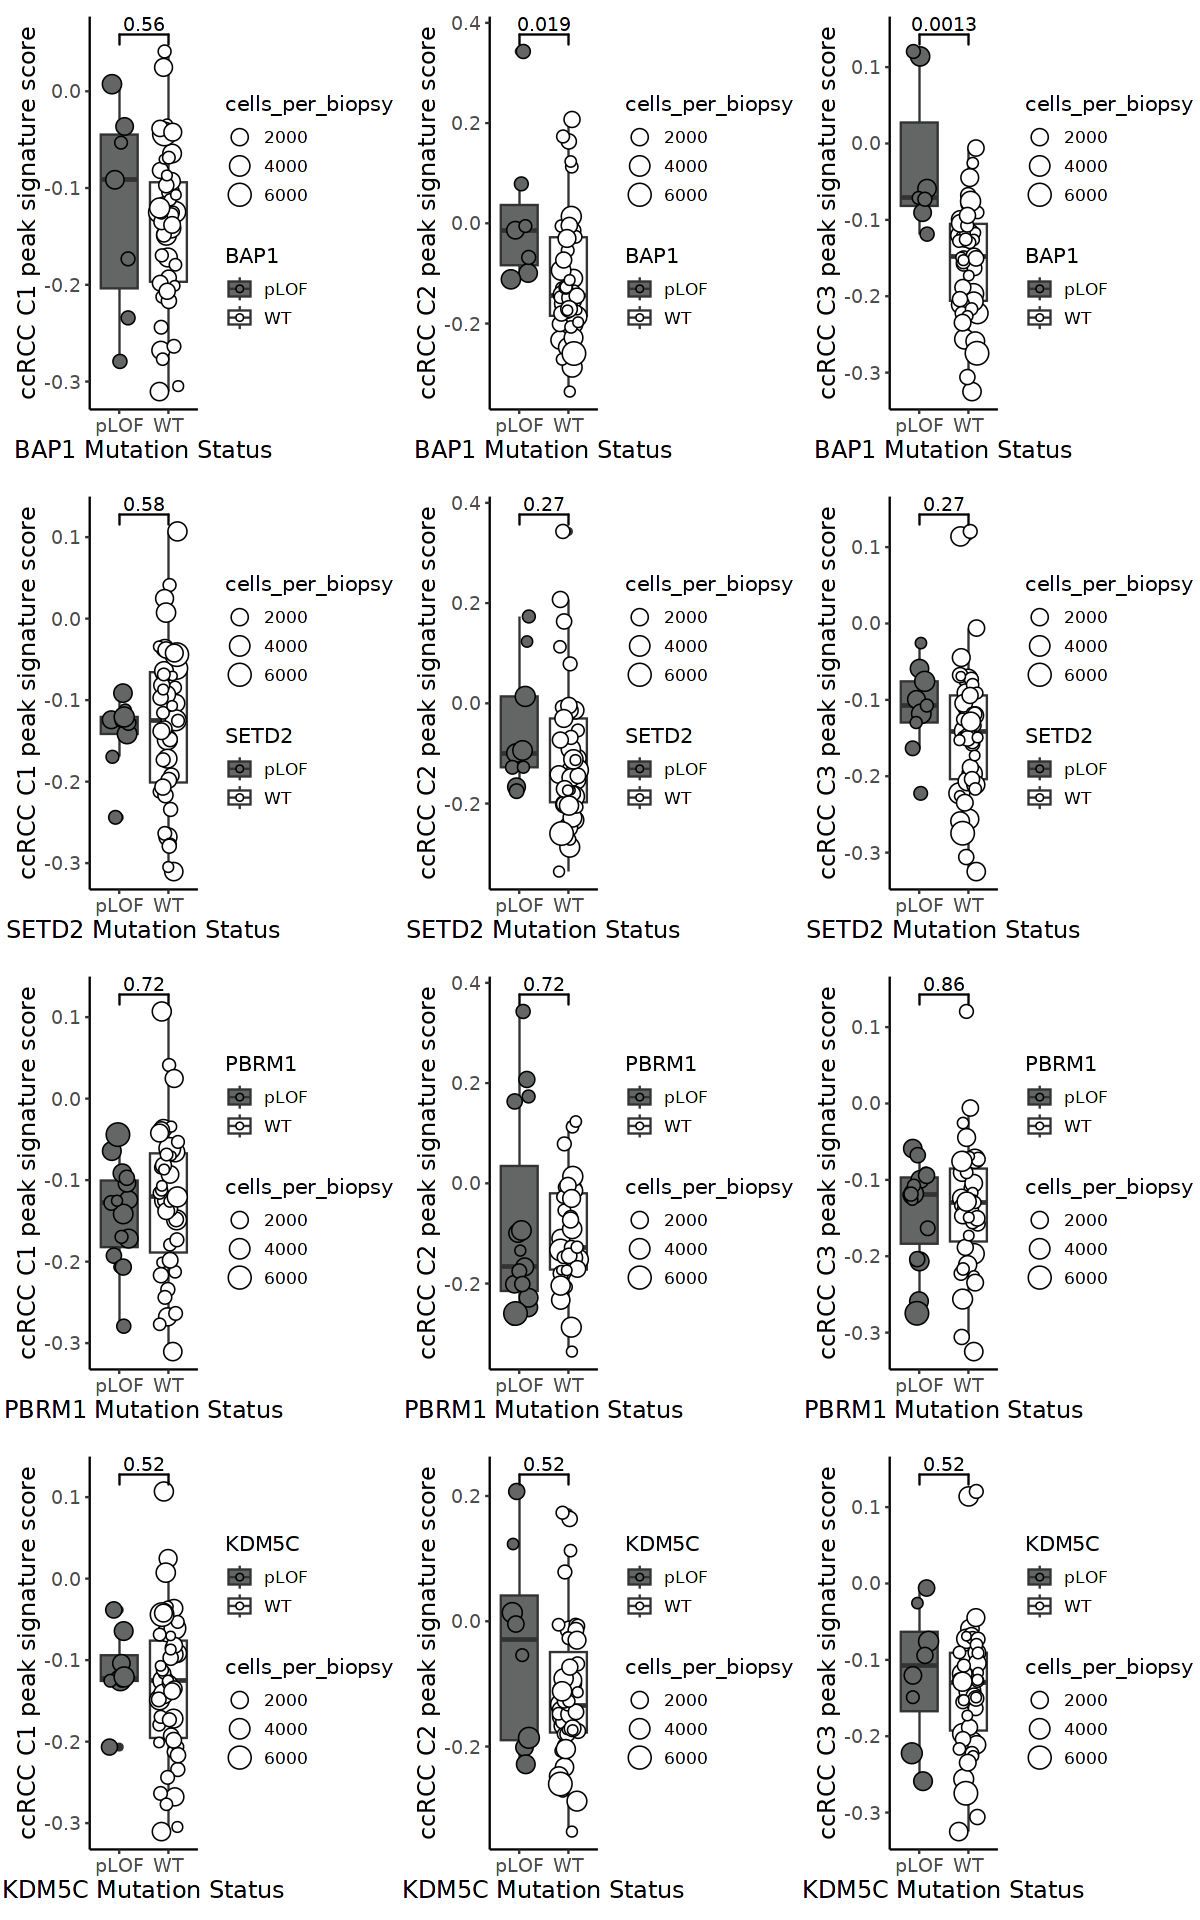

In [8]:
all_plots = list()
for (gene in c('BAP1','SETD2', 'PBRM1', 'KDM5C')) {
    
    value = glue('{gene}_LOF')
    metadata = ccrcc@meta.data %>% filter((ccrcc@meta.data[,value] == 1) | (ccrcc@meta.data[,gene] == 0))
    metadata[,gene] = ifelse(metadata[,gene] == 1, 'pLOF', 'WT')
    metadata[,gene] = factor(metadata[,gene], levels = c('pLOF','WT'))
    
    # Calculate q-values
    sigs = c('C1_signature', 'C2_signature', 'C3_signature')
    q_vals = list()
    for (i in 1:length(sigs)) {
        ft = sigs[i]
        df = metadata %>% group_by(biopsy, !!sym(gene)) %>%
            summarise(
            median_sig = median(!!sym(ft)))
        wt = (df %>% filter(!!sym(gene) == 'WT'))$median_sig
        mt = (df %>% filter(!!sym(gene) == 'pLOF'))$median_sig
        pval = (wilcox.test(mt, wt))$p.value
        y_scale_range = max(c(wt,mt)) - min(c(wt,mt))
        ypos = max(c(wt,mt)) + y_scale_range * 0.05

        q_vals[[ft]] = data.frame(signature = ft, p_val = pval, ypos = ypos, gene = gene)
    }
    q_vals_df = dplyr::bind_rows(q_vals)
    q_vals_df$p_adjust = p.adjust(q_vals_df$p_val, method = 'fdr')

    # Plot
    plot_list = list()
    for (cluster in c('C1','C2','C3')) {
        plot_list[[cluster]] = plot_signature_by_mutation(data = metadata, mutation_column = gene, signature = sym(glue('{cluster}_signature')), side = 'two.sided') +
            scale_size(range = c(2, 6)) + 
            scale_fill_manual(values = c('#646565', 'white')) + 
            ylab(glue('ccRCC {cluster} peak signature score')) + 
            geom_signif(xmin = 'pLOF', xmax = 'WT',
                        y_position = (q_vals_df %>% filter(signature == glue('{cluster}_signature')))$ypos,
                        annotation = c(formatC((q_vals_df %>% filter(signature == glue('{cluster}_signature')))$p_adjust,
                                               digits = 2)))
    }

    gene_plot = cowplot::plot_grid(plotlist = plot_list, ncol = 3)
    all_plots[[gene]] = gene_plot
}

options(repr.plot.width=10, repr.plot.height=16)
combo_plot = cowplot::plot_grid(plotlist = all_plots, nrow = 4)
combo_plot

## Panel B: Advanced stages

`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed"
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed"
Warning message:
"Computation failed in `stat_signif()

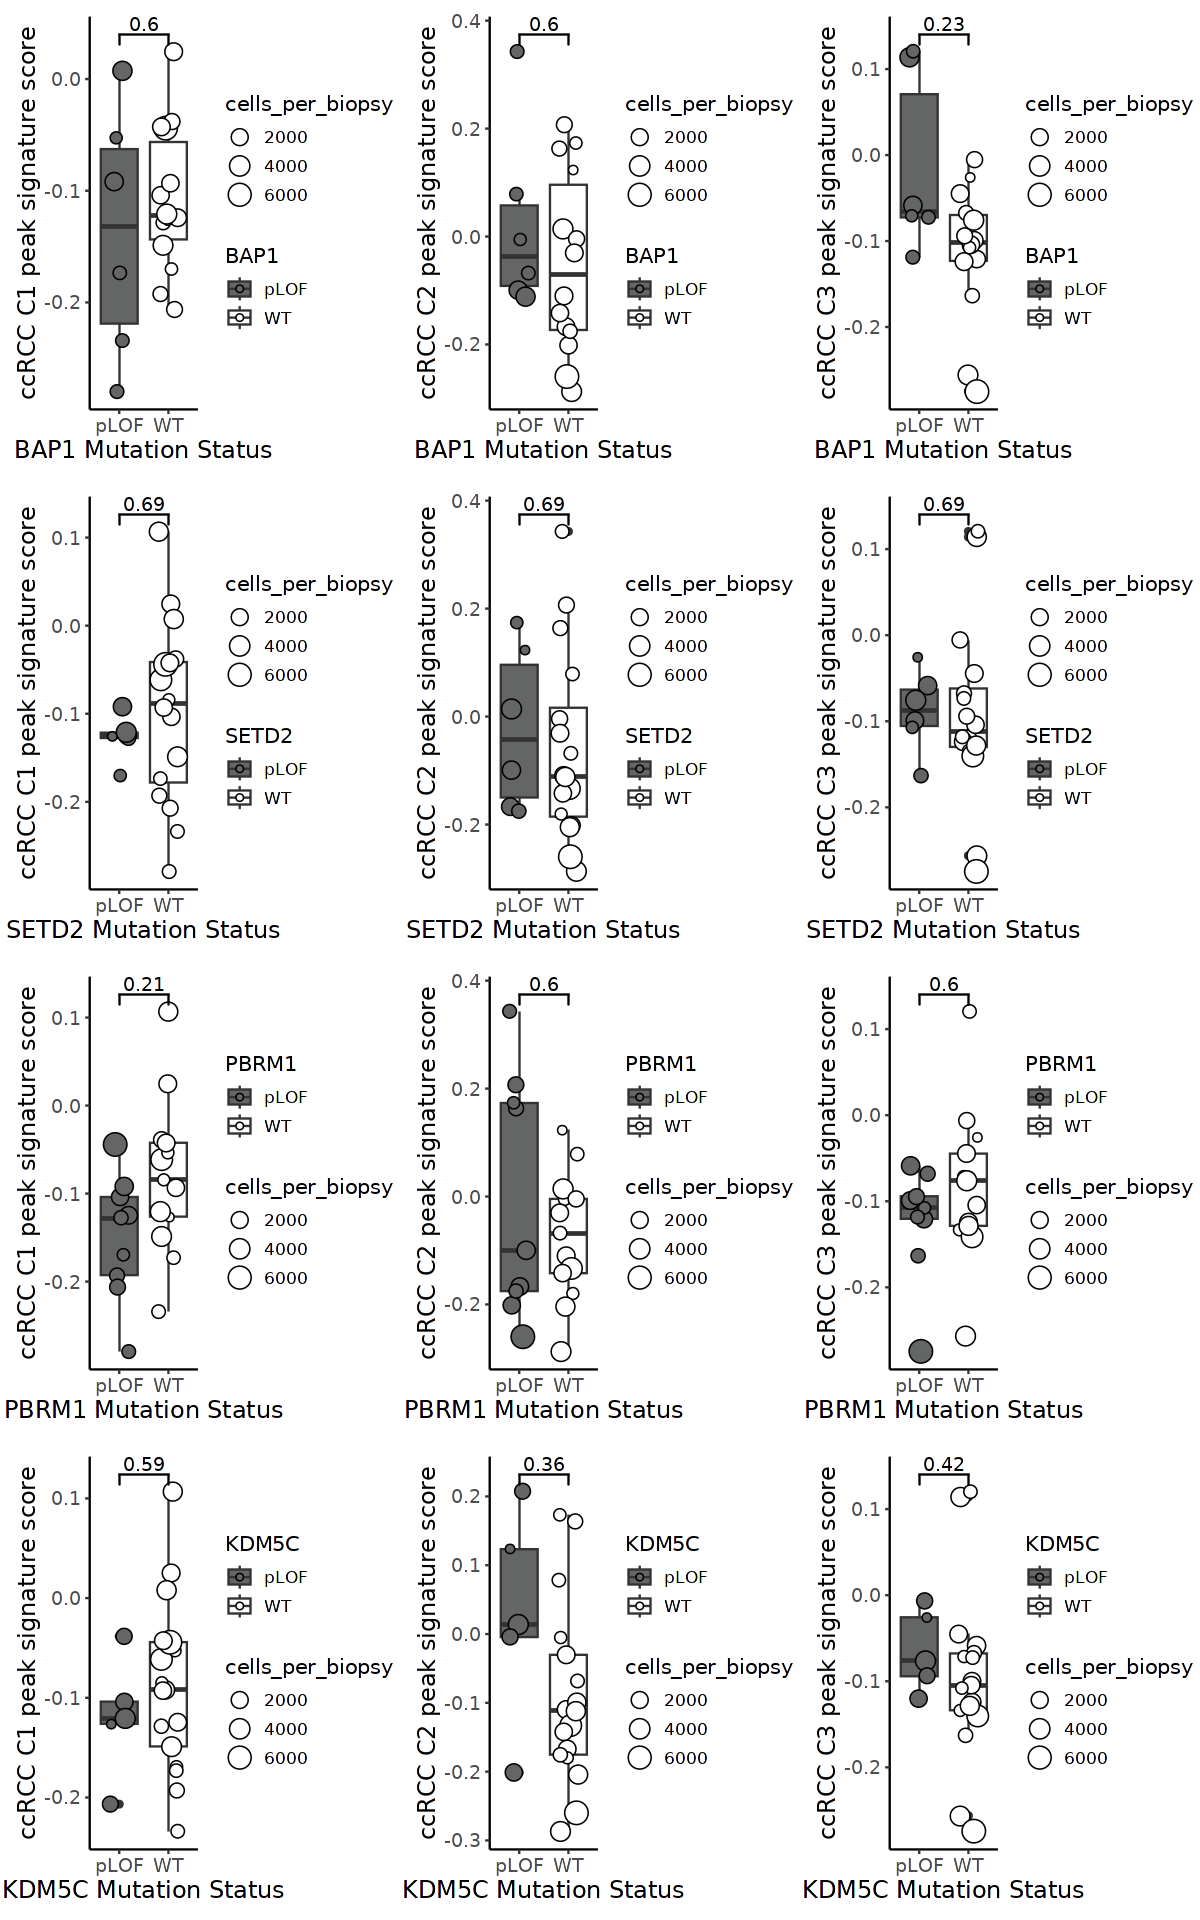

In [10]:
all_plots = list()
for (gene in c('BAP1','SETD2', 'PBRM1', 'KDM5C')) {
    
    value = glue('{gene}_LOF')
    metadata = ccrcc@meta.data %>% filter(((ccrcc@meta.data[,value] == 1) | (ccrcc@meta.data[,gene] == 0)) & (stage %in% c(3,4)))
    metadata[,gene] = ifelse(metadata[,gene] == 1, 'pLOF', 'WT')
    metadata[,gene] = factor(metadata[,gene], levels = c('pLOF','WT'))
        
    sigs = c('C1_signature', 'C2_signature', 'C3_signature')
    q_vals = list()
    for (i in 1:length(sigs)) {
        ft = sigs[i]
        df = metadata %>% group_by(biopsy, !!sym(gene)) %>%
            summarise(
            median_sig = median(!!sym(ft)))
        wt = (df %>% filter(!!sym(gene) == 'WT'))$median_sig
        mt = (df %>% filter(!!sym(gene) == 'pLOF'))$median_sig
        pval = (wilcox.test(mt, wt))$p.value
        y_scale_range = max(c(wt,mt)) - min(c(wt,mt))
        ypos = max(c(wt,mt)) + y_scale_range * 0.05

        q_vals[[ft]] = data.frame(signature = ft, p_val = pval, ypos = ypos, gene = gene)
    }
    q_vals_df = dplyr::bind_rows(q_vals)
    q_vals_df$p_adjust = p.adjust(q_vals_df$p_val, method = 'fdr')
    plot_list = list()
    for (cluster in c('C1','C2','C3')) {
        plot_list[[cluster]] = plot_signature_by_mutation(data = metadata, mutation_column = gene, signature = sym(glue('{cluster}_signature')), side = 'two.sided') +
            scale_size(range = c(2, 6)) + 
            scale_fill_manual(values = c('#646565', 'white')) + 
            ylab(glue('ccRCC {cluster} peak signature score')) + 
            geom_signif(xmin = 'pLOF', xmax = 'WT',
                        y_position = (q_vals_df %>% filter(signature == glue('{cluster}_signature')))$ypos,
                        annotation = c(formatC((q_vals_df %>% filter(signature == glue('{cluster}_signature')))$p_adjust,
                                               digits = 2)))
    }

    gene_plot = cowplot::plot_grid(plotlist = plot_list, ncol = 3)
    all_plots[[gene]] = gene_plot
}

options(repr.plot.width=10, repr.plot.height=16)
combo_plot = cowplot::plot_grid(plotlist = all_plots, nrow = 4)
combo_plot

# Figure S3C: Evaluating the impact of sarcomatoid features on the relationship between C3 program score and BAP1 mutation status

In [20]:
# Object
ccrcc = readRDS('allcells/tumor/seurat_obj/integrated_ccrcc_c0123_plof_anno_Oct2023.rds')

# C3 program peaks
da_peaks = read.table('/home/jupyter/scATAC_analysis/edit/snatac-rcc-manuscript-data/s2b_ccrcc_states_diffpeaks.txt', row.names = NULL, header = TRUE)
c3_peaks = (da_peaks %>% filter(cluster == 'C3'))$peak

**Calculate score and add to metadata**

In [22]:
c3_sigs = calculate_signature_scores(seurat_object = ccrcc, sig_peak_set = c3_peaks, pct.open = 0.1, final_score_name = 'cluster3_signature')
ccrcc = AddMetaData(ccrcc, metadata = c3_sigs)

Matching GC.percent distribution



## No sarcomatoid features

Custom `plot_signature_by_mutation` function

In [24]:
plot_signature_by_mutation <- function(data, mutation_column, signature, side='less') {
  # Convert mutation status to a factor
  data[[mutation_column]] <- as.factor(data[[mutation_column]])
  
  # Calculate the median signature for each biopsy
  signature_df <- data %>%
    group_by(biopsy, !!sym(mutation_column)) %>%
    summarise(
      total_cells = n(),
      median_sig = median(!!sym(signature)),
      .groups = 'drop'
    )

  # Create the box plot with overlaid jittered points
  p <- ggplot(signature_df, aes(x = !!sym(mutation_column), y = median_sig)) +
    geom_boxplot(alpha = 1, fill = "white") +
    geom_jitter(width = 0.2, alpha = 1, fill = 'grey', aes(size = total_cells), stroke = 0.5, shape = 21) +
    labs(
      x = paste(mutation_column, "Mutation Status"),
      y = paste(signature)
    ) +
    theme_classic() +
    theme(
      text = element_text(size = 14),
      legend.title = element_text(size = 12),
      legend.text = element_text(size = 10),
      plot.margin = margin(t = 10, r = 10, b = 10, l = 10, unit = "pt")
    )  +
    geom_signif(comparisons = list(c('0', '1')), map_signif_level = FALSE, test="wilcox.test", test.args=list(alternative = side))
    }
    

`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed"


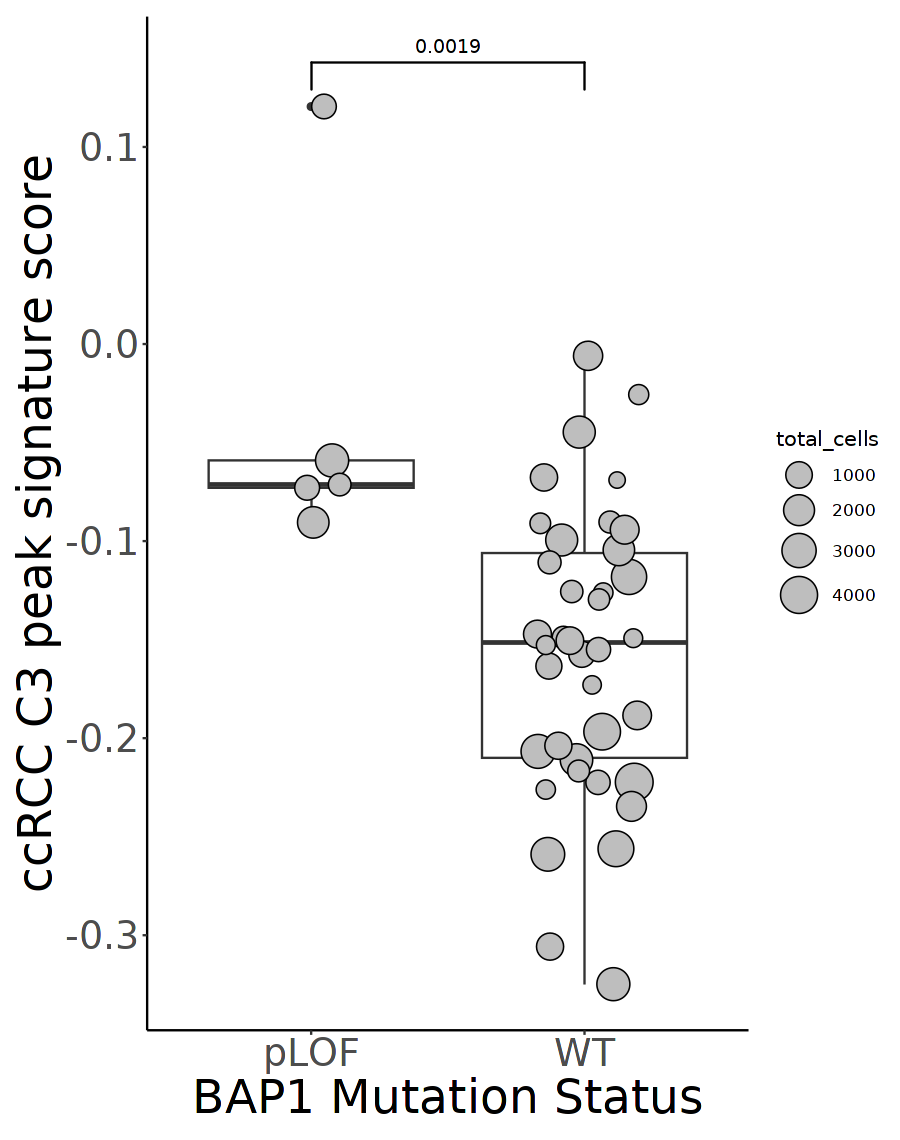

In [26]:
# Limit analysis to samples w/o sarcomatoid features, and either pLOF or WT for BAP1
metadata = ccrcc@meta.data %>% filter((BAP1_LOF == 1) | (BAP1 == 0)) %>% filter(sarcomatoid_features == 0)
metadata[,'BAP1'] = ifelse(metadata[,'BAP1'] == 1, 'pLOF', 'WT')
metadata[,'BAP1'] = factor(metadata[,'BAP1'], levels = c('pLOF','WT'))

# Compare signature scores between pLOF and WT
df = metadata %>% group_by(biopsy, BAP1) %>%
    summarise(
    median_sig = median(cluster3_signature))
wt = (df %>% filter(BAP1 == 'WT'))$median_sig
mt = (df %>% filter(BAP1 == 'pLOF'))$median_sig
pval = (wilcox.test(mt, wt))$p.value
y_scale_range = max(c(wt,mt)) - min(c(wt,mt))
ypos = max(c(wt,mt)) + y_scale_range * 0.05

# Plot
options(repr.plot.width=7.5, repr.plot.height=9.5)
plot_signature_by_mutation(data = metadata, mutation_column = 'BAP1', signature = 'cluster3_signature') +
    scale_size(range = c(4, 10)) + ylab('ccRCC C3 peak signature score') +
    geom_signif(
        xmin = 'pLOF', xmax = 'WT', y_position = ypos,
        annotation = c(formatC(pval, digits = 2))) + 
theme(text = element_text(size = 28))

## All samples

Custom `plot_signature_by_mutation` function

In [27]:
plot_signature_by_mutation <- function(data, mutation_column, signature, side = 'less') {
  # Convert mutation status to a factor
  data[[mutation_column]] <- as.factor(data[[mutation_column]])
  
  # Convert sarcomatoid_status to a factor
  data$sarcomatoid_features <- as.factor(data$sarcomatoid_features)
  
  # Calculate the median signature for each biopsy
  signature_df <- data %>%
    group_by(biopsy, !!sym(mutation_column), sarcomatoid_features) %>%
    summarise(
      total_cells = n(),
      median_sig = median(!!sym(signature)),
      .groups = 'drop'
    )

  # Create the box plot with overlaid jittered points
  p <- ggplot(signature_df, aes(x = !!sym(mutation_column), y = median_sig)) +
    geom_boxplot(alpha = 1, fill = 'white') +
    geom_jitter(width = 0.2, alpha = 1, aes(size = total_cells, fill = sarcomatoid_features), stroke = 0.5, shape = 21) +
    labs(
      x = paste(mutation_column, "Mutation Status"),
      y = paste(signature)
    ) +
    theme_classic() +
    theme(
      text = element_text(size = 14),
      legend.title = element_text(size = 12),
      legend.text = element_text(size = 10),
      plot.margin = margin(t = 10, r = 10, b = 10, l = 10, unit = "pt")
    ) +
    scale_fill_manual(
      values = c('0' = 'grey', '1' = '#1f78b4', 'NA' = 'white'), 
      na.value = 'white',
      guide = guide_legend(title = "Sarcomatoid Status")
    ) +
    geom_signif(comparisons = list(c('0', '1')), map_signif_level = FALSE, test = "wilcox.test", test.args = list(alternative = side))
  
  return(p)
}


`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed"


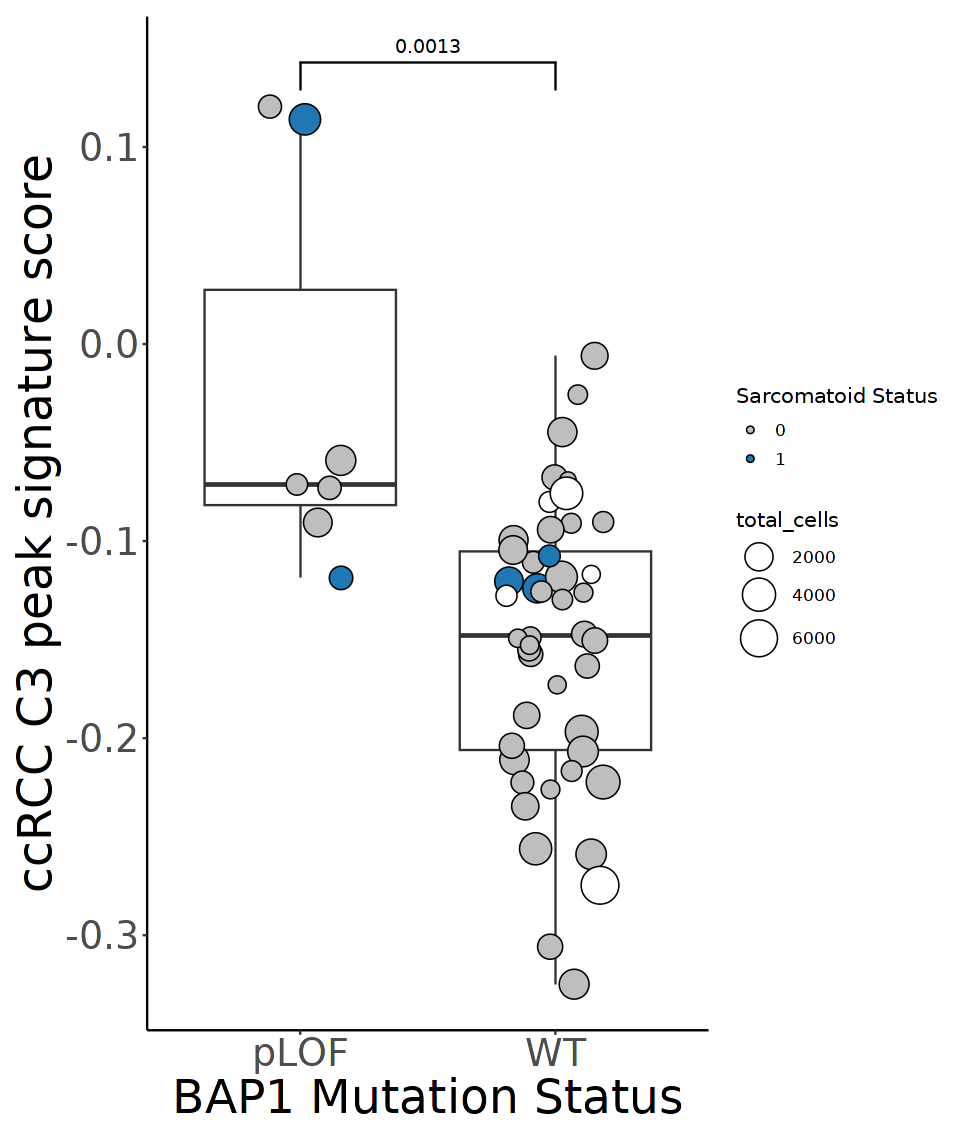

In [28]:
# Limit analysis to samples pLOF or WT for BAP1
metadata = ccrcc@meta.data %>% filter((BAP1_LOF == 1) | (BAP1 == 0))
metadata[,'BAP1'] = ifelse(metadata[,'BAP1'] == 1, 'pLOF', 'WT')
metadata[,'BAP1'] = factor(metadata[,'BAP1'], levels = c('pLOF','WT'))

# Compare signature scores between pLOF and WT
df = metadata %>% group_by(biopsy, BAP1) %>%
    summarise(
    median_sig = median(cluster3_signature))
wt = (df %>% filter(BAP1 == 'WT'))$median_sig
mt = (df %>% filter(BAP1 == 'pLOF'))$median_sig
qval = p.adjust((wilcox.test(mt, wt))$p.value, n = 3)
y_scale_range = max(c(wt,mt)) - min(c(wt,mt))
ypos = max(c(wt,mt)) + y_scale_range * 0.05

#Plot
options(repr.plot.width=8, repr.plot.height=9.5)
plot_signature_by_mutation(data = metadata, mutation_column = 'BAP1', signature = 'cluster3_signature') +
    scale_size(range = c(4, 10)) + ylab('ccRCC C3 peak signature score') +
    geom_signif(
        xmin = 'pLOF', xmax = 'WT', y_position = ypos,
        annotation = c(formatC(qval, digits = 2))) + 
theme(text = element_text(size = 28))

# Figure S3D: Comparing disease stages between patients with a BAP1 mutated tumor vs BAP1 wt tumor

In [29]:
metadata = ccrcc@meta.data

bap1_stage = metadata %>% filter((BAP1_LOF == 1) | (BAP1 == 0)) %>%
    dplyr::select(participant, BAP1_LOF, stage) %>% distinct()
bap1_stage$early_adv = ifelse(bap1_stage$stage %in% c(3,4), 'Advanced', 'Early')
bap1_stage %>% group_by(early_adv, BAP1_LOF) %>% dplyr::count()

early_adv,BAP1_LOF,n
<chr>,<dbl>,<int>
Advanced,0,13
Advanced,1,6
Early,0,32
Early,1,1


In [30]:
# Fisher's Exact Test for p-value
fisher.test(table(bap1_stage$early_adv, bap1_stage$BAP1_LOF), simulate.p.value = TRUE, B = 10000)


	Fisher's Exact Test for Count Data

data:  table(bap1_stage$early_adv, bap1_stage$BAP1_LOF)
p-value = 0.007069
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.00143483 0.67546185
sample estimates:
odds ratio 
0.07156741 


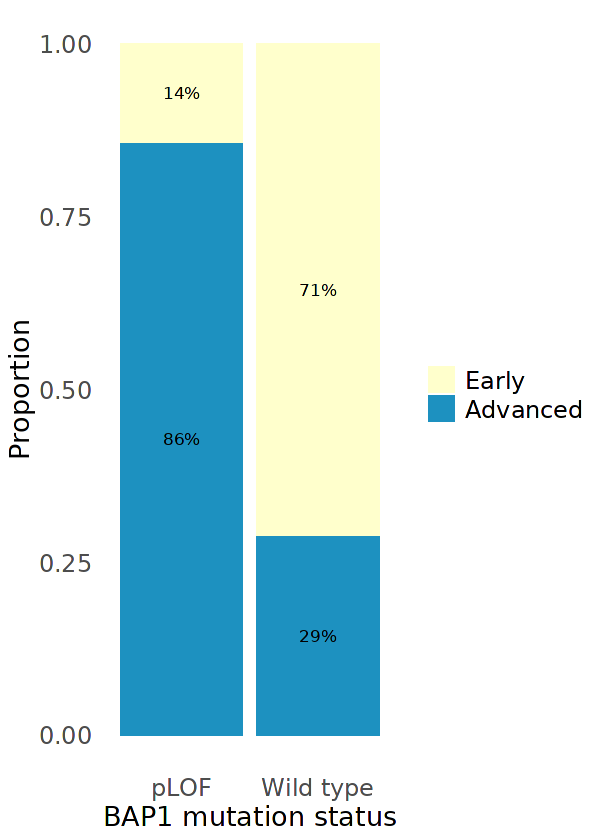

In [31]:
# Proportions of disease stage between BAP1 mut vs wt
prop_data <- data.frame(prop.table(table(bap1_stage$BAP1_LOF, bap1_stage$early_adv), margin = 1))

# Calculate the counts for annotations
count_data <- as.data.frame(table(bap1_stage$BAP1_LOF, bap1_stage$early_adv))
names(count_data) <- c("Var1", "Var2", "Count")

# Merge counts back into your proportion data for annotations
annotated_data <- merge(prop_data, count_data, by = c("Var1", "Var2"))


options(repr.plot.width=5, repr.plot.height=7)
# Plot
annotated_data$Var1 = factor(annotated_data$Var1, levels = c(1, 0))
annotated_data$Var2 = factor(annotated_data$Var2, levels = c('Early', 'Advanced'))
ggplot(annotated_data, aes(x = Var1, y = Freq, fill = Var2)) + 
  geom_bar(stat = 'identity') + 
  geom_text(aes(label = scales::percent(Freq, accuracy = 1), y = Freq), position = position_stack(vjust = 0.5), size = 3.5) + 
  theme_classic() + 
  theme(legend.position = 'right',
        legend.title = element_blank(), 
        legend.text = element_text(size = 14),
        axis.title.y = element_text(size = 16),
        axis.title.x= element_text(size = 16),
        axis.ticks = element_blank(), 
        axis.line = element_blank(),
        axis.text.x = element_text(size = 14),
        axis.text.y = element_text(size = 14)) + 
  ylab('Proportion') +
  labs(fill = "Subtype") + scale_x_discrete(labels = c('pLOF', 'Wild type')) + xlab('BAP1 mutation status') +
scale_fill_manual(values = c('#FFFFCC','#1D91C0'))


# Figure S3E: Comparing Wu et al BAP1-associated peak sets with our study's BAP1-associated peak sets

Read in ccRCC tumor object.

In [4]:
ccrcc = readRDS('allcells/tumor/seurat_obj/integrated_ccrcc_c0123_plof_anno_wchromvar_Oct2023.rds')
DefaultAssay(ccrcc) = 'ATAC'

## Wu et al BAP1-associated peak sets

Quantify Wu et al BAP1-associated peak sets in our ccRCC object.

In [5]:
# Read in table with peak sets
library(readxl)
wu_peaks = read_excel('allcells/tumor/wuetal_bap1/wuetal_suppdata5.xlsx',sheet = 3, na = 'NA')
sig_peaks = wu_peaks %>% dplyr::select(peak, DAP_direction) %>% distinct()

# Quantify peaks in our multi-cohort dataset
peaks_query_regions = sig_peaks$peak
peaks_query_regions = data.frame(peaks_query_regions)
peaks_query_regions = peaks_query_regions %>% tidyr::separate(col = peaks_query_regions, into = c('chr', 'start', 'stop'))
peaks_query_regions$grange_format = paste0(peaks_query_regions$chr, ':', peaks_query_regions$start, '-', peaks_query_regions$stop)
peaks_query_grange = GRanges(seqnames = peaks_query_regions$grange_format)
counts = FeatureMatrix(Fragments(ccrcc), features = peaks_query_grange)
saveRDS(counts, 'allcells/tumor/wuetal_bap1/ftmatrix.rds')

# Define peaks neg and pos assoc with BAP1 mutation
down = (sig_peaks %>% filter(DAP_direction == 'Down'))$peak
up = (sig_peaks %>% filter(DAP_direction == 'Up'))$peak


Warning message:
"Expecting numeric in D3534 / R3534C4: got '9.13652686559891e-314'"
Warning message:
"Expecting numeric in D3757 / R3757C4: got '6.18817221416161e-320'"


In [7]:
# Add wu et al peak quantification as a new assay in the obj and normalize the data
counts = readRDS('allcells/tumor/wuetal_bap1/ftmatrix.rds')
chrom_assay = CreateChromatinAssay(counts,fragments = Fragments(ccrcc))
ccrcc[['wuetal']] = chrom_assay
DefaultAssay(ccrcc) = 'wuetal'
ccrcc <- RunTFIDF(ccrcc)

Performing TF-IDF normalization



Subset data to tumor cells from BAP1 pLOF or BAP1 WT. 

In [11]:
DefaultAssay(ccrcc) = 'wuetal'
groupa = (ccrcc@meta.data %>% filter(BAP1_LOF == 1))$new_barcodes
groupb = (ccrcc@meta.data %>% filter(BAP1 == 0))$new_barcodes

tumor_bap1 = subset(ccrcc, cells = c(groupa, groupb))

For plotting, create an average accessibility object, getting an average accessibility at each regper sample

In [12]:
DefaultAssay(tumor_bap1) = 'wuetal'
sigpeak_obj = tumor_bap1
Idents(sigpeak_obj) = 'biopsy'
DefaultAssay(sigpeak_obj) = 'wuetal'
sigpeak_obj = AverageExpression(sigpeak_obj, return.seurat = T)

Centering and scaling data matrix



Add in desired metadata for the heatmap

In [13]:
sigpeak_obj$biopsy = row.names(sigpeak_obj@meta.data)
add_meta = tumor_bap1@meta.data %>% dplyr::select(c('biopsy','cohort','BAP1_LOF', 'stage')) %>% distinct()
row.names(add_meta) = add_meta$biopsy

sigpeak_obj = AddMetaData(sigpeak_obj, metadata = add_meta)


Heatmap of regions depleted w BAP1 mutation

Warning message in brewer.pal(10, "Accent"):
"n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
"
`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



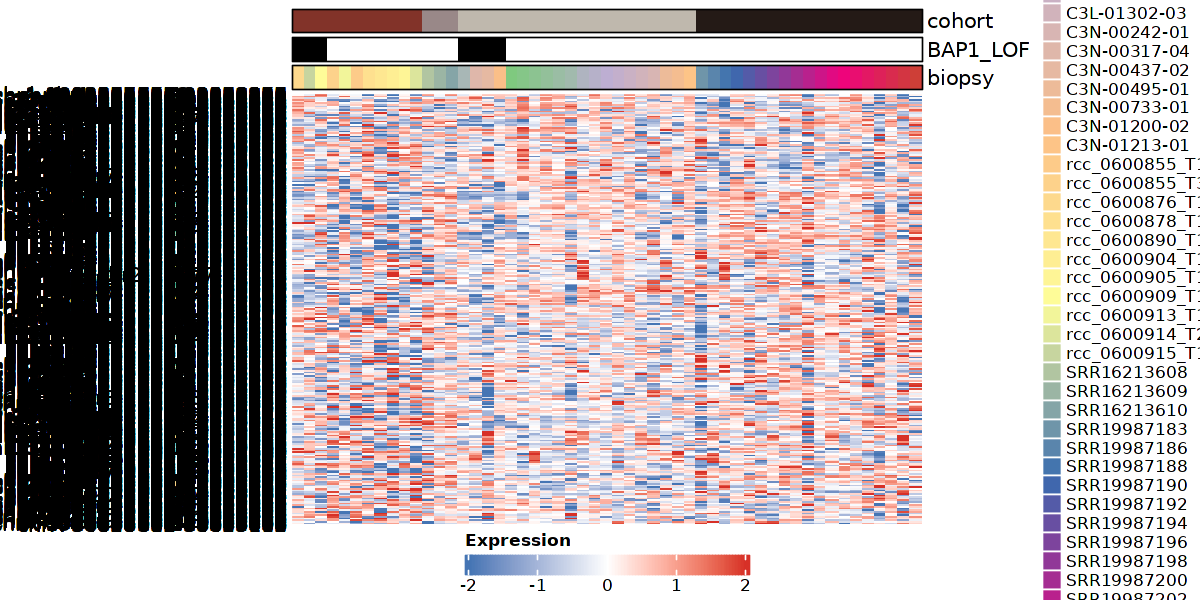

In [15]:
tumor_cols <- c('black','white')
cohort_cols <- c('#823329','#998888','#BFB8AD', '#241a16' )
sample_cols <- colorRampPalette(brewer.pal(10, "Accent"))(65)

sigpeak_obj$BAP1_LOF = factor(sigpeak_obj$BAP1_LOF, levels = c(1,0))

options(repr.plot.width=10, repr.plot.height=5)
plot_heatmap(sigpeak_obj, markers = down,anno_var = c('cohort','BAP1_LOF','biopsy'),
             anno_colors = list(cohort_cols, tumor_cols,sample_cols), sort_var = c('cohort','BAP1_LOF'))

Heatmap of regions with more accessibility with a BAP1 mutation

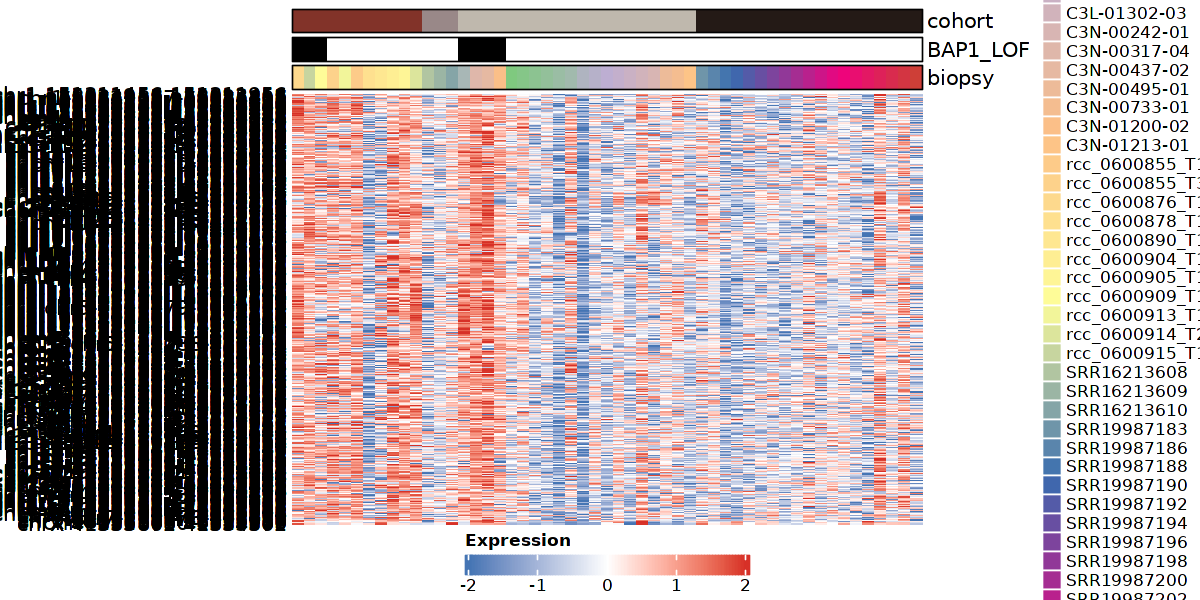

In [16]:
plot_heatmap(sigpeak_obj, markers = up,anno_var = c('cohort','BAP1_LOF','biopsy'),
             anno_colors = list(cohort_cols, tumor_cols,sample_cols), sort_var = c('cohort','BAP1_LOF'))



## Camp et al BAP1-associated peak sets

In [17]:
markers = read.table('../../snatac-rcc-manuscript-data/s3a_bap1_ccrcc_diffpeaks.txt', row.names = NULL)
filtered_markers = markers %>% filter(p_val_adj < 0.05, avg_log2FC > 1)
dim(filtered_markers)

[1] 4014    7

Create an average accessibility object, getting an average per sample

In [18]:
DefaultAssay(tumor_bap1) = 'ATAC'
sigpeak_obj = subset(tumor_bap1, features = filtered_markers$gene)
Idents(sigpeak_obj) = 'biopsy'
DefaultAssay(sigpeak_obj) = 'ATAC'
sigpeak_obj = AverageExpression(sigpeak_obj, return.seurat = T)

Centering and scaling data matrix



Add in desired metadata for the heatmap

In [19]:
sigpeak_obj$biopsy = row.names(sigpeak_obj@meta.data)
add_meta = tumor_bap1@meta.data %>% dplyr::select(c('biopsy','cohort','BAP1_LOF', 'stage')) %>% distinct()
row.names(add_meta) = add_meta$biopsy

sigpeak_obj = AddMetaData(sigpeak_obj, metadata = add_meta)


Heatmap of regions with more accessibility with a BAP1 mutation

Warning message in brewer.pal(10, "Accent"):
"n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
"
`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



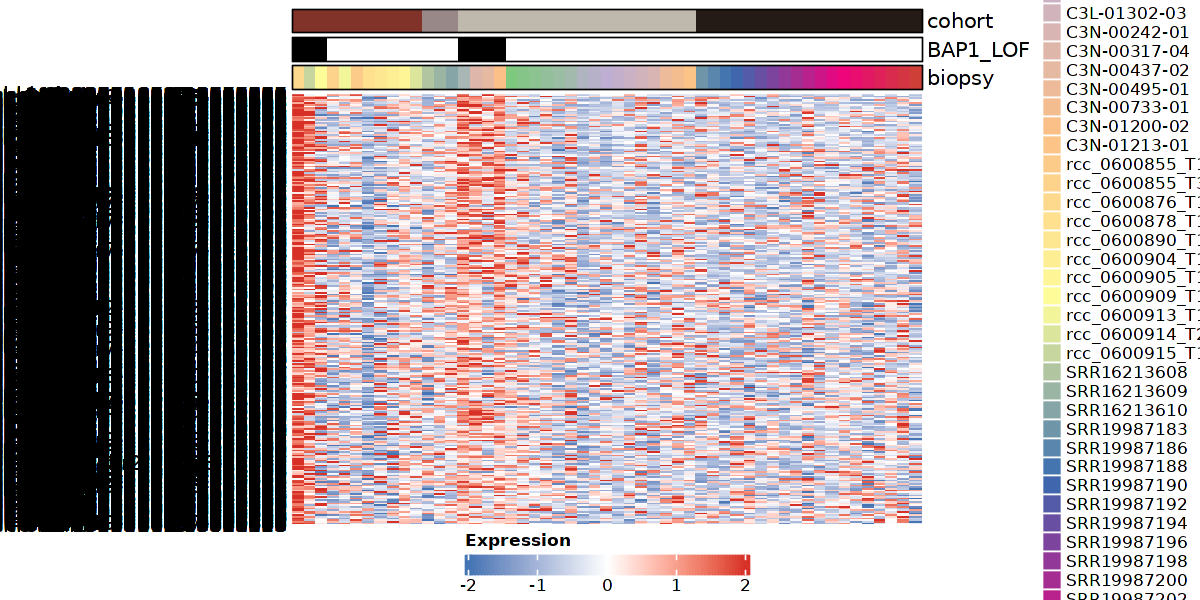

In [20]:
tumor_cols <- c('black','white')
cohort_cols <- c('#823329','#998888','#BFB8AD', '#241a16' )
sample_cols <- colorRampPalette(brewer.pal(10, "Accent"))(65)

sigpeak_obj$BAP1_LOF = factor(sigpeak_obj$BAP1_LOF, levels = c(1,0))
options(repr.plot.width=10, repr.plot.height=5)
plot_heatmap(sigpeak_obj, markers = filtered_markers$gene,anno_var = c('cohort','BAP1_LOF','biopsy'),
             anno_colors = list(cohort_cols, tumor_cols,sample_cols), sort_var = c('cohort','BAP1_LOF'))

Select markers associated with less accessibility with a BAP1 mutation

In [21]:
filtered_markers = markers %>% filter(p_val_adj < 0.05, avg_log2FC < -1)
dim(filtered_markers)

[1] 128   7

Create an average accessibility object, getting an average per sample

In [22]:
DefaultAssay(tumor_bap1) = 'ATAC'
sigpeak_obj = subset(tumor_bap1, features = filtered_markers$gene)
Idents(sigpeak_obj) = 'biopsy'
DefaultAssay(sigpeak_obj) = 'ATAC'
sigpeak_obj = AverageExpression(sigpeak_obj, return.seurat = T)

Centering and scaling data matrix



Add in desired metadata for the heatmap

In [23]:
sigpeak_obj$biopsy = row.names(sigpeak_obj@meta.data)
add_meta = tumor_bap1@meta.data %>% dplyr::select(c('biopsy','cohort','BAP1_LOF', 'stage')) %>% distinct()
row.names(add_meta) = add_meta$biopsy

sigpeak_obj = AddMetaData(sigpeak_obj, metadata = add_meta)


Heatmap of regions with depleted accessibility with a BAP1 mutation

Warning message in brewer.pal(10, "Accent"):
"n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
"


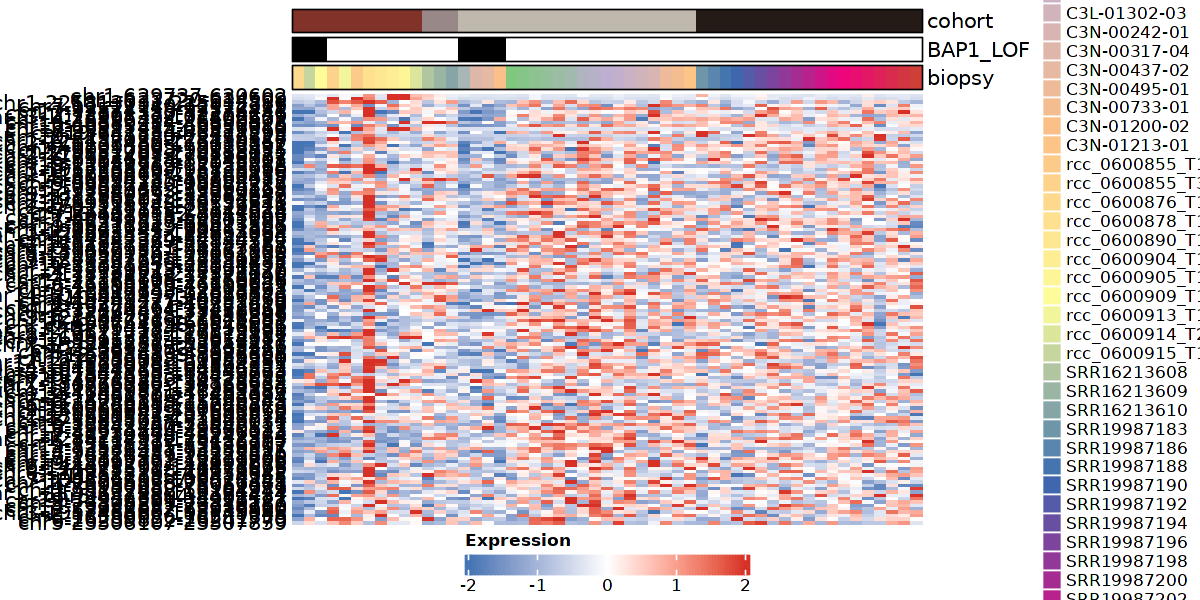

In [24]:
tumor_cols <- c('black','white')
cohort_cols <- c('#823329','#998888','#BFB8AD', '#241a16' )
sample_cols <- colorRampPalette(brewer.pal(10, "Accent"))(65)

sigpeak_obj$BAP1_LOF = factor(sigpeak_obj$BAP1_LOF, levels = c(1,0))
options(repr.plot.width=10, repr.plot.height=5)
plot_heatmap(sigpeak_obj, markers = filtered_markers$gene,anno_var = c('cohort','BAP1_LOF','biopsy'),
             anno_colors = list(cohort_cols, tumor_cols,sample_cols), sort_var = c('cohort','BAP1_LOF'))


# Figure S3F: Evaluating impact of sarcomatoid features on the relationships between immune cell type frequencies and BAP1 mutation status

In [4]:
allcells = readRDS('allcells/seurat_obj/integrated_allcohorts_seuratobj_geneactivity_lsi_metadata_qc_motifs_annotated_detailed.rds')

Get pLOF mutation info per sample

In [5]:
sample_biopsy_mapping = allcells@meta.data %>% dplyr::select(sample,biopsy) %>% distinct()
mutations = read.table('../../snatac-rcc-manuscript-data/comut_muts.txt', sep = '\t')
mutations_filtered = mutations %>% filter(!(value %in% c('Missense','In frame indel', 'Unable to determine')))
combined_muts_bysample = dplyr::left_join(mutations_filtered, sample_biopsy_mapping, by = 'biopsy')

Warning message in dplyr::left_join(mutations_filtered, sample_biopsy_mapping, by = "biopsy"):
"Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 26 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning."


Create mutation matrix to add to Seurat object's metadata

In [6]:
# Create starter matrix based off of samples w/ mutations
mutation_matrix = combined_muts_bysample %>% dplyr::select(c('sample','category')) %>%
  tidyr::pivot_wider(names_from = category, values_from = category, values_fn = length, values_fill = 0)
sampleids = unique(allcells$sample)

# Samples with no mutation info should be NAs
no_mut_data = c('rcc_0600855_T2', 'rcc_0600920_T1','rcc_RCCT1324-T1A')
missing_rows <- data.frame(sample = no_mut_data)
missing_rows[, unique(colnames(mutation_matrix)[-1])] <- NA

# If a sample did get sequencing but no mutations are found the entry should be 0
new_rows <- data.frame(sample = setdiff(sampleids, c(mutation_matrix$sample, no_mut_data)))
new_rows[, unique(colnames(mutation_matrix)[-1])] <- 0

# Concatenate together
mutation_matrix <- rbind(mutation_matrix, missing_rows, new_rows)

# Set column names that will be in metadata
colnames(mutation_matrix) = c('sample','SETD2_LOF', 'KDM5C_LOF','VHL_LOF','BAP1_LOF','PBRM1_LOF')

# Index by cell barcode and add to Seurat object
shared_states_lof = dplyr::left_join(allcells@meta.data %>% dplyr::select('new_barcodes', 'sample'), mutation_matrix, by = 'sample')
row.names(shared_states_lof) = shared_states_lof$new_barcodes
shared_states_lof$new_barcodes = NULL
allcells = AddMetaData(allcells, shared_states_lof)

Filter to cells to QC-passing from patients with late stage clear cell ccRCC

In [7]:
metadata = allcells@meta.data %>% filter((BAP1_LOF == 1) | (BAP1 == 0))
metadata = metadata %>% filter((broad_celltype_excluded != 'Excluded') & (stage %in% c('3','4')) & (histology == 'Clear cell'))
metadata$BAP1_status = ifelse(metadata$BAP1_LOF == 1, 'pLOF', 'WT')

Calculate immune cell type proportion

In [8]:
# Grouping by cell type, biopsy, and BAP1 status
grouped_df <- metadata %>%
  group_by(broad_celltype_excluded, biopsy, BAP1_status, sarcomatoid_features) %>%
  summarise(cell_count = n(), .groups = 'drop')

# Calculating total cells per biopsy
total_cells_per_biopsy <- grouped_df %>%
  group_by(biopsy) %>%
  summarise(total_cells = sum(cell_count), .groups = 'drop')

# Merging to get total cells in each biopsy alongside each group
merged_df <- merge(grouped_df, total_cells_per_biopsy, by = "biopsy")

# Calculating the proportion
merged_df <- merged_df %>%
  mutate(proportion = cell_count / total_cells)

# Selecting relevant columns
all_everything_props = merged_df %>%
  dplyr::select(biopsy, broad_celltype_excluded, BAP1_status, sarcomatoid_features, proportion, total_cells)


In [24]:
all_everything_props$BAP1_status = factor(all_everything_props$BAP1_status, levels = c('WT','pLOF'))
immune_infiltrate_plot = all_everything_props %>% filter(!(broad_celltype_excluded %in% c('Tumor',"Endothelial", "Perivascular cell", "Fibroblast")))
immune_infiltrate_plot$broad_celltype_excluded = factor(immune_infiltrate_plot$broad_celltype_excluded,
                                                        levels = rev(c('CD8 T cell', 'T-helper','T-reg','NK','Plasma cell','B cell','TAM','Monocyte','MoDC', 'cDC')))


In [25]:
immune_infiltrate_plot <- immune_infiltrate_plot %>%
  mutate(sarcomatoid_features = case_when(
    sarcomatoid_features == 0 ~ "absent",
    sarcomatoid_features == 1 ~ "present",
    is.na(sarcomatoid_features) ~ "no information"
  ))

In [26]:
head(immune_infiltrate_plot)

,biopsy,broad_celltype_excluded,BAP1_status,sarcomatoid_features,proportion,total_cells
,<chr>,<fct>,<fct>,<chr>,<dbl>,<int>
1,C3L-00004-01,CD8 T cell,WT,absent,0.036033520,3580
2,C3L-00004-01,MoDC,WT,absent,0.006424581,3580
3,C3L-00004-01,Monocyte,WT,absent,0.031005587,3580
4,C3L-00004-01,NK,WT,absent,0.033240223,3580
5,C3L-00004-01,cDC,WT,absent,0.004189944,3580
6,C3L-00004-01,T-reg,WT,absent,0.019832402,3580


Nominal and adjusted p-values for immune cell type frequency comparisons

In [14]:
celltypes = unique(immune_infiltrate_plot$broad_celltype_excluded)
results = list()
for (i in 1:length(celltypes)) {
    celltype = celltypes[i]
    celltype_meta = immune_infiltrate_plot
    celltype_meta$broad_celltype_excluded = as.character(celltype_meta$broad_celltype_excluded)
    celltype_meta = celltype_meta %>% filter(broad_celltype_excluded == celltype)
    bap1_mt_prop_vector = (celltype_meta %>% filter(BAP1_status == 'pLOF'))$proportion
    bap1_wt_prop_vector =(celltype_meta %>% filter(BAP1_status == 'WT'))$proportion
    test = wilcox.test(x = bap1_mt_prop_vector, y = bap1_wt_prop_vector)
    side = ifelse(median(bap1_mt_prop_vector) > median(bap1_wt_prop_vector), 'pLOF', 'WT')
    results[[i]] = data.frame(celltype = celltype, pvalue = test$p.value, side = side)
}

results_df = dplyr::bind_rows(results)
results_df$padjust = p.adjust(p = results_df$pvalue, method = 'fdr')
results_df

celltype,pvalue,side,padjust
<fct>,<dbl>,<chr>,<dbl>
CD8 T cell,0.129669763,pLOF,0.43223254
MoDC,0.391296870,pLOF,0.80866193
Monocyte,0.002063983,pLOF,0.02063983
NK,0.718059856,WT,0.83141678
cDC,0.831416777,pLOF,0.83141678
T-reg,0.404330963,pLOF,0.80866193
B cell,0.826923077,pLOF,0.83141678
Plasma cell,0.825174825,pLOF,0.83141678
T-helper,0.601547988,pLOF,0.83141678


## All samples

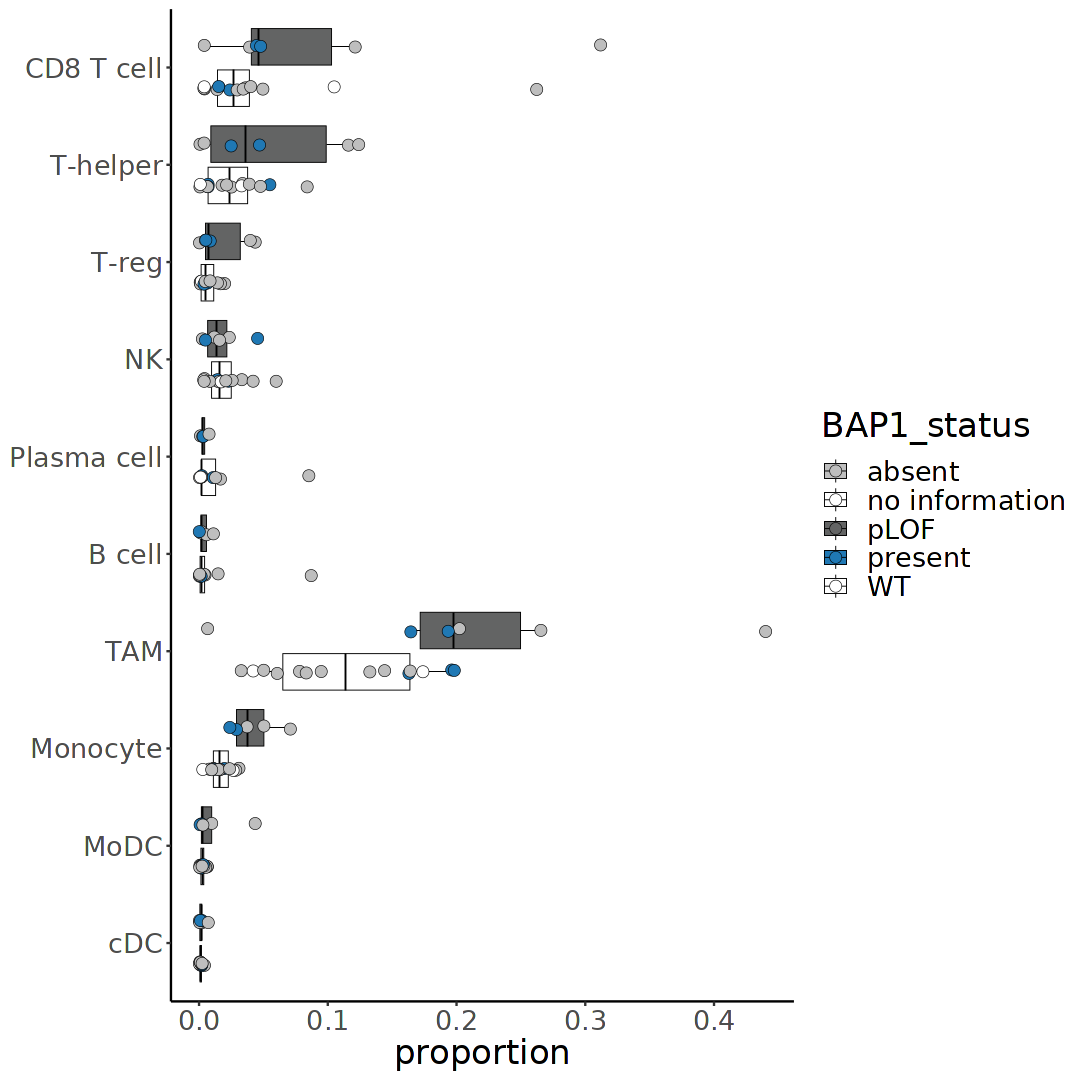

In [15]:
options(repr.plot.width = 9, repr.plot.height = 9)

immune_infiltrate_plot %>% 
  ggplot(aes(x = broad_celltype_excluded, y = proportion, fill = BAP1_status)) +
  geom_boxplot(outlier.shape = NA, color = 'black', lwd = 0.2, position = position_dodge(0.85)) +
  geom_point(position = position_jitterdodge(dodge.width = 0.85, jitter.width = 0.1), 
             alpha = 1, 
             aes(group = BAP1_status, fill = factor(sarcomatoid_features)), 
             stroke = 0.2, 
             shape = 21,
             size = 3) +
  coord_flip() + 
  theme_classic() + 
  theme(
    text = element_text(size = 20),
    axis.title.y = element_blank()
  ) +
  scale_fill_manual(values = c('grey','white','#636464', '#1f78b4', 'white')) +
  scale_color_manual(values = c('black', 'white'))



## Subset to those without sarcomatoid features

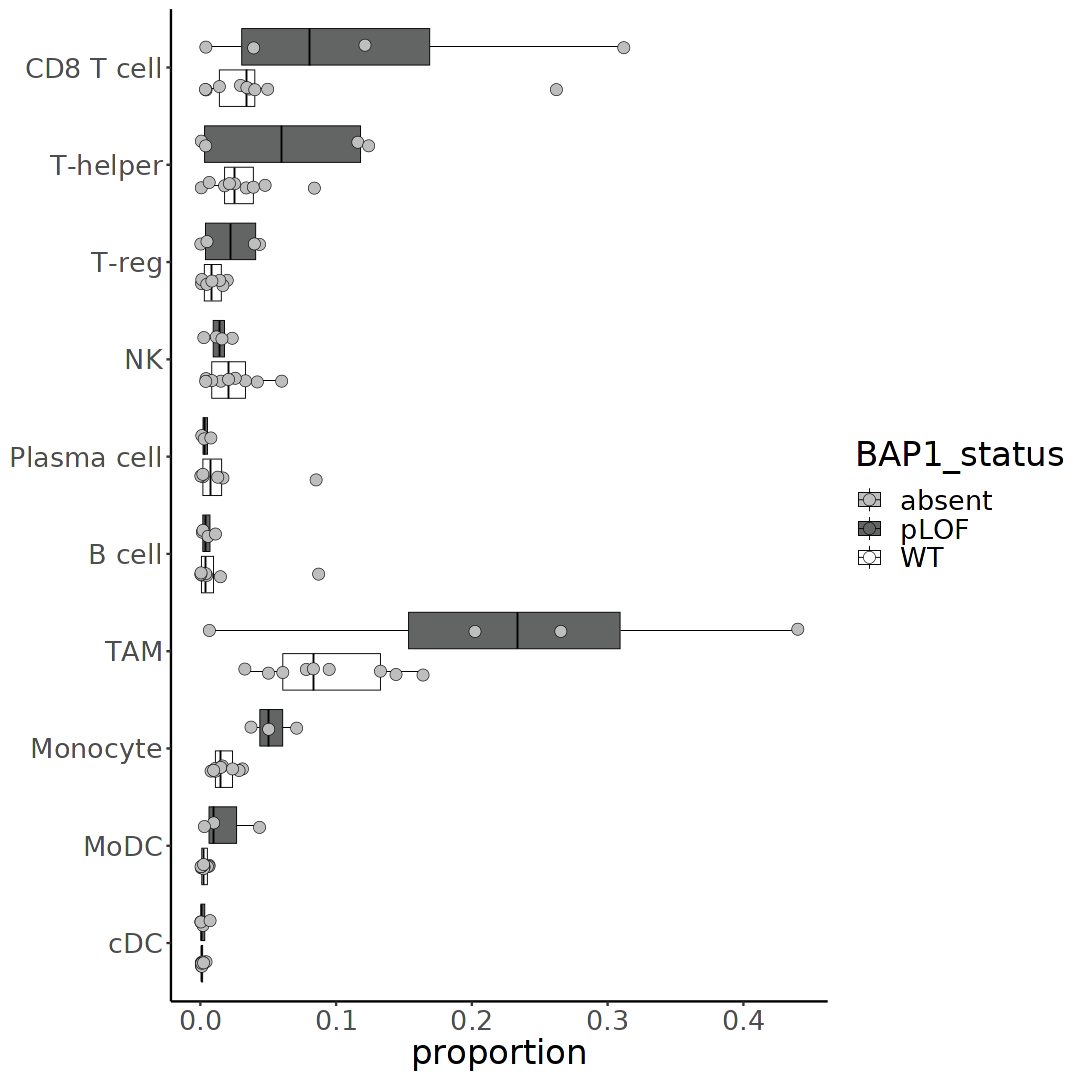

In [16]:
options(repr.plot.width = 9, repr.plot.height = 9)

immune_infiltrate_plot %>% filter(sarcomatoid_features == 'absent') %>% 
  ggplot(aes(x = broad_celltype_excluded, y = proportion, fill = BAP1_status)) +
  geom_boxplot(outlier.shape = NA, color = 'black', lwd = 0.2, position = position_dodge(0.85)) +
  geom_point(position = position_jitterdodge(dodge.width = 0.85, jitter.width = 0.1), 
             alpha = 1, 
             aes(group = BAP1_status, fill = factor(sarcomatoid_features)), 
             stroke = 0.2, 
             shape = 21,
             size = 3) +
  coord_flip() + 
  theme_classic() + 
  theme(
    text = element_text(size = 20),
    axis.title.y = element_blank()
  ) +
  scale_fill_manual(values = c('grey','#636464', 'white')) +
  scale_color_manual(values = c('black', 'white'))


Nominal and adjusted p-values for immune cell type frequency comparisons. Limiting to samples w/o sarcomatoid features

In [23]:
immune_infiltrate_plot

biopsy,broad_celltype_excluded,BAP1_status,sarcomatoid_features,proportion,total_cells
<chr>,<fct>,<fct>,<chr>,<dbl>,<int>


In [27]:
immune_infiltrate_plot = immune_infiltrate_plot %>% filter(sarcomatoid_features == 'absent')
celltypes = unique(immune_infiltrate_plot$broad_celltype_excluded)
results = list()
for (i in 1:length(celltypes)) {
    celltype = celltypes[i]
    celltype_meta = immune_infiltrate_plot
    celltype_meta$broad_celltype_excluded = as.character(celltype_meta$broad_celltype_excluded)
    celltype_meta = celltype_meta %>% filter(broad_celltype_excluded == celltype)
    bap1_mt_prop_vector = (celltype_meta %>% filter(BAP1_status == 'pLOF'))$proportion
    bap1_wt_prop_vector =(celltype_meta %>% filter(BAP1_status == 'WT'))$proportion
    test = wilcox.test(x = bap1_mt_prop_vector, y = bap1_wt_prop_vector)
    side = ifelse(median(bap1_mt_prop_vector) > median(bap1_wt_prop_vector), 'pLOF', 'WT')
    results[[i]] = data.frame(celltype = celltype, pvalue = test$p.value, side = side)
}

results_df = dplyr::bind_rows(results)
results_df$padjust = p.adjust(p = results_df$pvalue, method = 'fdr')
results_df

celltype,pvalue,side,padjust
<fct>,<dbl>,<chr>,<dbl>
CD8 T cell,0.413986014,pLOF,0.82517483
MoDC,0.063636364,pLOF,0.31818182
Monocyte,0.009090909,pLOF,0.09090909
NK,0.413986014,WT,0.82517483
cDC,0.808080808,pLOF,0.82517483
T-reg,0.648484848,pLOF,0.82517483
B cell,0.787878788,WT,0.82517483
Plasma cell,0.714285714,WT,0.82517483
T-helper,0.825174825,pLOF,0.82517483


# Table S3

## Sheet A: Differentially accessible peaks between BAP1 mt and wt tumor cells

In [4]:
markers = read.table('allcells/tumor/findmarkers/BAP1/latestage_ccrcc_BAP1_LOF_vs_not.txt', row.names = NULL)
filtered_markers = markers %>% filter((p_val_adj < 0.05) & (abs(avg_log2FC) >1))
# total pos and neg asssoc peaks
dim(filtered_markers)
filtered_markers$group = ifelse(filtered_markers$avg_log2FC < 0, 'BAP1 WT', 'BAP1 pLOF')
filtered_markers[,'row.names'] = NULL
write.table(filtered_markers, file = '../../snatac-rcc-manuscript-data/s3a_bap1_ccrcc_diffpeaks.txt', sep = '\t', quote = F, col.names = T, row.names = F)

[1] 4142    7

## Sheet B: TF binding site motif enrichment in BAP1 mutation associated peaks

Define regions with increased accessibility in BAP1 mut tumor cells

In [5]:
filtered_up = markers %>% filter((p_val_adj < 0.05) & (avg_log2FC >1))
dim(filtered_up)

[1] 4014    7

Subset analysis to late stage BAP1 pLOF or WT tumor cells

In [6]:
ccrcc = readRDS('allcells/tumor/seurat_obj/integrated_ccrcc_c0123_plof_anno_Oct2023.rds')
groupa = (ccrcc@meta.data %>% filter(BAP1_LOF == 1, stage %in% c(3,4)))$new_barcodes
groupb = (ccrcc@meta.data %>% filter(BAP1 == 0,stage %in% c(3,4)))$new_barcodes

tumor_bap1 = subset(ccrcc, cells = c(groupa, groupb))

Determine enriched TFs via hypergeometric test

In [7]:
DefaultAssay(tumor_bap1) = 'ATAC'

# For peaks enriched in BAP1 mt
## Define a set of background peaks
## Find peaks that are open in a significant portion of cells
percent_to_num_cells = ceiling(nrow(tumor_bap1@meta.data) * 0.1)
open_peaks <- AccessiblePeaks(tumor_bap1, min.cells = percent_to_num_cells)

## Match the overall GC content in the peak set
meta.feature <- GetAssayData(tumor_bap1, assay = "ATAC", slot = "meta.features")
peaks_matched <- MatchRegionStats(
meta.feature = meta.feature[open_peaks, ],
query.feature = meta.feature[filtered_up$gene, ]
)

# Determine enrichment of motifs in peak set
df1 <- FindMotifs(
    object = tumor_bap1,
    features = filtered_up$gene,
    background = peaks_matched
    )

Matching GC.percent distribution

Testing motif enrichment in 4014 regions



In [9]:
write.table(df1 %>% filter(p.adjust < 0.05),
           file = '../../snatac-rcc-manuscript-data/s3b_BAP1_pLOF_tfmotifs.txt', sep = '\t', quote = F, row.names = F, col.names = T)


## Sheet C: Enriched pathways in BAP1 mutation associated peak set using GREAT

In [10]:
header = read.table('allcells/tumor/great/greatExportAll_forheader.tsv', fill = TRUE, sep = "\t", quote = "", row.names = NULL)
header = unlist(unname(t(header[1,])[,1]))
keep = c('GO Biological Process')

In [11]:
great_results = read.table('allcells/tumor/great/BAP1/BAP1_LOF_up_hg19_latestage_pathways.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]
# GREAT default term filtering
great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) 
dim(great_results)

[1] 35 22

In [12]:
write.table(great_results, '../../snatac-rcc-manuscript-data/s3c_BAP1_pLOF_GREAT_GOBP_output.txt', sep = '\t', quote = F, row.names = F, col.names = T)

## Writing out tables to Excel workbook
Switch to python kernel

In [1]:
import pandas as pd

In [2]:
bap1_daps = pd.read_csv('snatac-rcc-manuscript-data/s3a_bap1_ccrcc_diffpeaks.txt', sep = '\t')
bap1_daps.head()

bap1_plof_tf_motifs = pd.read_csv('snatac-rcc-manuscript-data/s3b_BAP1_pLOF_tfmotifs.txt', sep = '\t')
bap1_plof_tf_motifs.head()

bap1_plof_pathways = pd.read_csv('snatac-rcc-manuscript-data/s3c_BAP1_pLOF_GREAT_GOBP_output.txt', sep = '\t')
bap1_plof_pathways.head()


,Ontology,ID,Desc,BinomRank,BinomP,BinomBonfP,BinomFdrQ,RegionFoldEnrich,ExpRegions,ObsRegions,...,HyperRank,HyperP,HyperBonfP,HyperFdrQ,GeneFoldEnrich,ExpGenes,ObsGenes,TotalGenes,GeneSetCov,TermCov
0,GO Biological Process,GO:0002687,positive regulation of leukocyte migration,32,3.228343e-15,3.370390e-11,1.053247e-12,2.931961,24.89801,73,...,662,0.001704,1.000000,0.026880,1.740608,14.93731,26,68,0.006561,0.382353
1,GO Biological Process,GO:0002685,regulation of leukocyte migration,34,7.468837e-15,7.797466e-11,2.293372e-12,2.501667,37.17521,93,...,362,0.000059,0.618598,0.001709,1.830840,20.20930,37,92,0.009336,0.402174
2,GO Biological Process,GO:0002690,positive regulation of leukocyte chemotaxis,44,1.994931e-14,2.082708e-10,4.733427e-12,3.011942,21.91277,66,...,589,0.001083,1.000000,0.019189,1.889659,11.64231,22,53,0.005551,0.415094
3,GO Biological Process,GO:0002688,regulation of leukocyte chemotaxis,55,6.082967e-13,6.350618e-09,1.154658e-10,2.668204,26.60966,71,...,477,0.000327,1.000000,0.007164,1.909054,13.61931,26,62,0.006561,0.419355
4,GO Biological Process,GO:0050921,positive regulation of chemotaxis,61,1.489716e-12,1.555264e-08,2.549612e-10,2.187289,46.17588,101,...,265,0.000008,0.081243,0.000307,2.016868,17.35364,35,79,0.008832,0.443038


In [3]:
with pd.ExcelWriter('snatac-rcc-manuscript-data/table_S3.xlsx') as writer:  
    bap1_daps.to_excel(writer, sheet_name='A', index = False)
    bap1_plof_tf_motifs.to_excel(writer, sheet_name='B', index = False)
    bap1_plof_pathways.to_excel(writer, sheet_name='C', index = False)

Add README with titles in excel app. 